In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
# -----------------------
# 1. Load and Clean News
# -----------------------
news_path = '../data/raw_analyst_rating_cleaned.csv'
news_df = pd.read_csv(news_path, parse_dates=['date'])

news_df['headline'] = news_df['headline'].astype(str)
news_df['date'] = pd.to_datetime(news_df['date']).dt.date


In [3]:
# Sentiment Analysis - TextBlob
def get_textblob_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except Exception as e:
        print(f"TextBlob Error: {e}")
        return 0

news_df['sentiment_textblob'] = news_df['headline'].apply(get_textblob_sentiment)
daily_sentiment_textblob = news_df.groupby('date')['sentiment_textblob'].mean().reset_index()
daily_sentiment_textblob.columns = ['Date', 'Avg_Sentiment_TextBlob']
daily_sentiment_textblob.to_csv('../data/daily_sentiment_textblob.csv', index=False)

In [4]:
# Sentiment Analysis - VADER
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    try:
        return analyzer.polarity_scores(text)['compound']
    except Exception as e:
        print(f"VADER Error: {e}")
        return 0

news_df['sentiment_vader'] = news_df['headline'].apply(get_vader_sentiment)
daily_sentiment_vader = news_df.groupby('date')['sentiment_vader'].mean().reset_index()
daily_sentiment_vader.columns = ['Date', 'Avg_Sentiment_VADER']
daily_sentiment_vader.to_csv('../data/daily_sentiment_vader.csv', index=False)

In [5]:
# ------------------------
# 2. Process Stock Data & Correlation
# ------------------------
stocks_folder = '../data/yfinance_data'

def process_stock_files(sentiment_df, sentiment_col, label):
    stock_returns = {}

    for file in os.listdir(stocks_folder):
        if file.endswith('.csv'):
            stock_name = file.replace('.csv', '')
            df = pd.read_csv(os.path.join(stocks_folder, file), parse_dates=['Date'])
            df['Date'] = pd.to_datetime(df['Date']).dt.date
            df.sort_values('Date', inplace=True)
            df['Daily_Return'] = df['Close'].pct_change()
            df = df[['Date', 'Daily_Return']].dropna()

            merged = pd.merge(df, sentiment_df, on='Date')
            corr = merged['Daily_Return'].corr(merged[sentiment_col])

            stock_returns[stock_name] = {
                'Data': merged,
                'Correlation': corr
            }
            print(f"📊 {label} | {stock_name}: Correlation = {corr:.4f}")

    return stock_returns

def plot_correlation_grid(stock_returns, sentiment_col, label):
    num_stocks = len(stock_returns)
    cols = 3
    rows = (num_stocks + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, (stock, result) in enumerate(stock_returns.items()):
        merged = result['Data']
        ax = axes[i]
        sns.scatterplot(data=merged, x=sentiment_col, y='Daily_Return', ax=ax)
        ax.set_title(f'{stock} (\u03c1 = {result["Correlation"]:.2f})')
        ax.axhline(0, color='gray', linestyle='--')
        ax.axvline(0, color='gray', linestyle='--')
        ax.grid(True)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle(f"📈 {label} Sentiment vs Daily Return", fontsize=18, y=1.02)
    plt.savefig(f"sentiment_vs_return_{label.lower()}.png", bbox_inches='tight')
    plt.show()

📊 VADER | AAPL_historical_data: Correlation = 0.1479
📊 VADER | AMZN_historical_data: Correlation = 0.0827
📊 VADER | GOOG_historical_data: Correlation = 0.1278
📊 VADER | META_historical_data: Correlation = 0.1637
📊 VADER | MSFT_historical_data: Correlation = 0.1233
📊 VADER | NVDA_historical_data: Correlation = 0.1165
📊 VADER | TSLA_historical_data: Correlation = 0.1183


C:\Users\user\AppData\Local\Temp\ipykernel_14144\1595436494.py:50: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(f"sentiment_vs_return_{label.lower()}.png", bbox_inches='tight')
c:\Users\user\Desktop\Predicting-Price-Moves-with-News-Sentiment\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


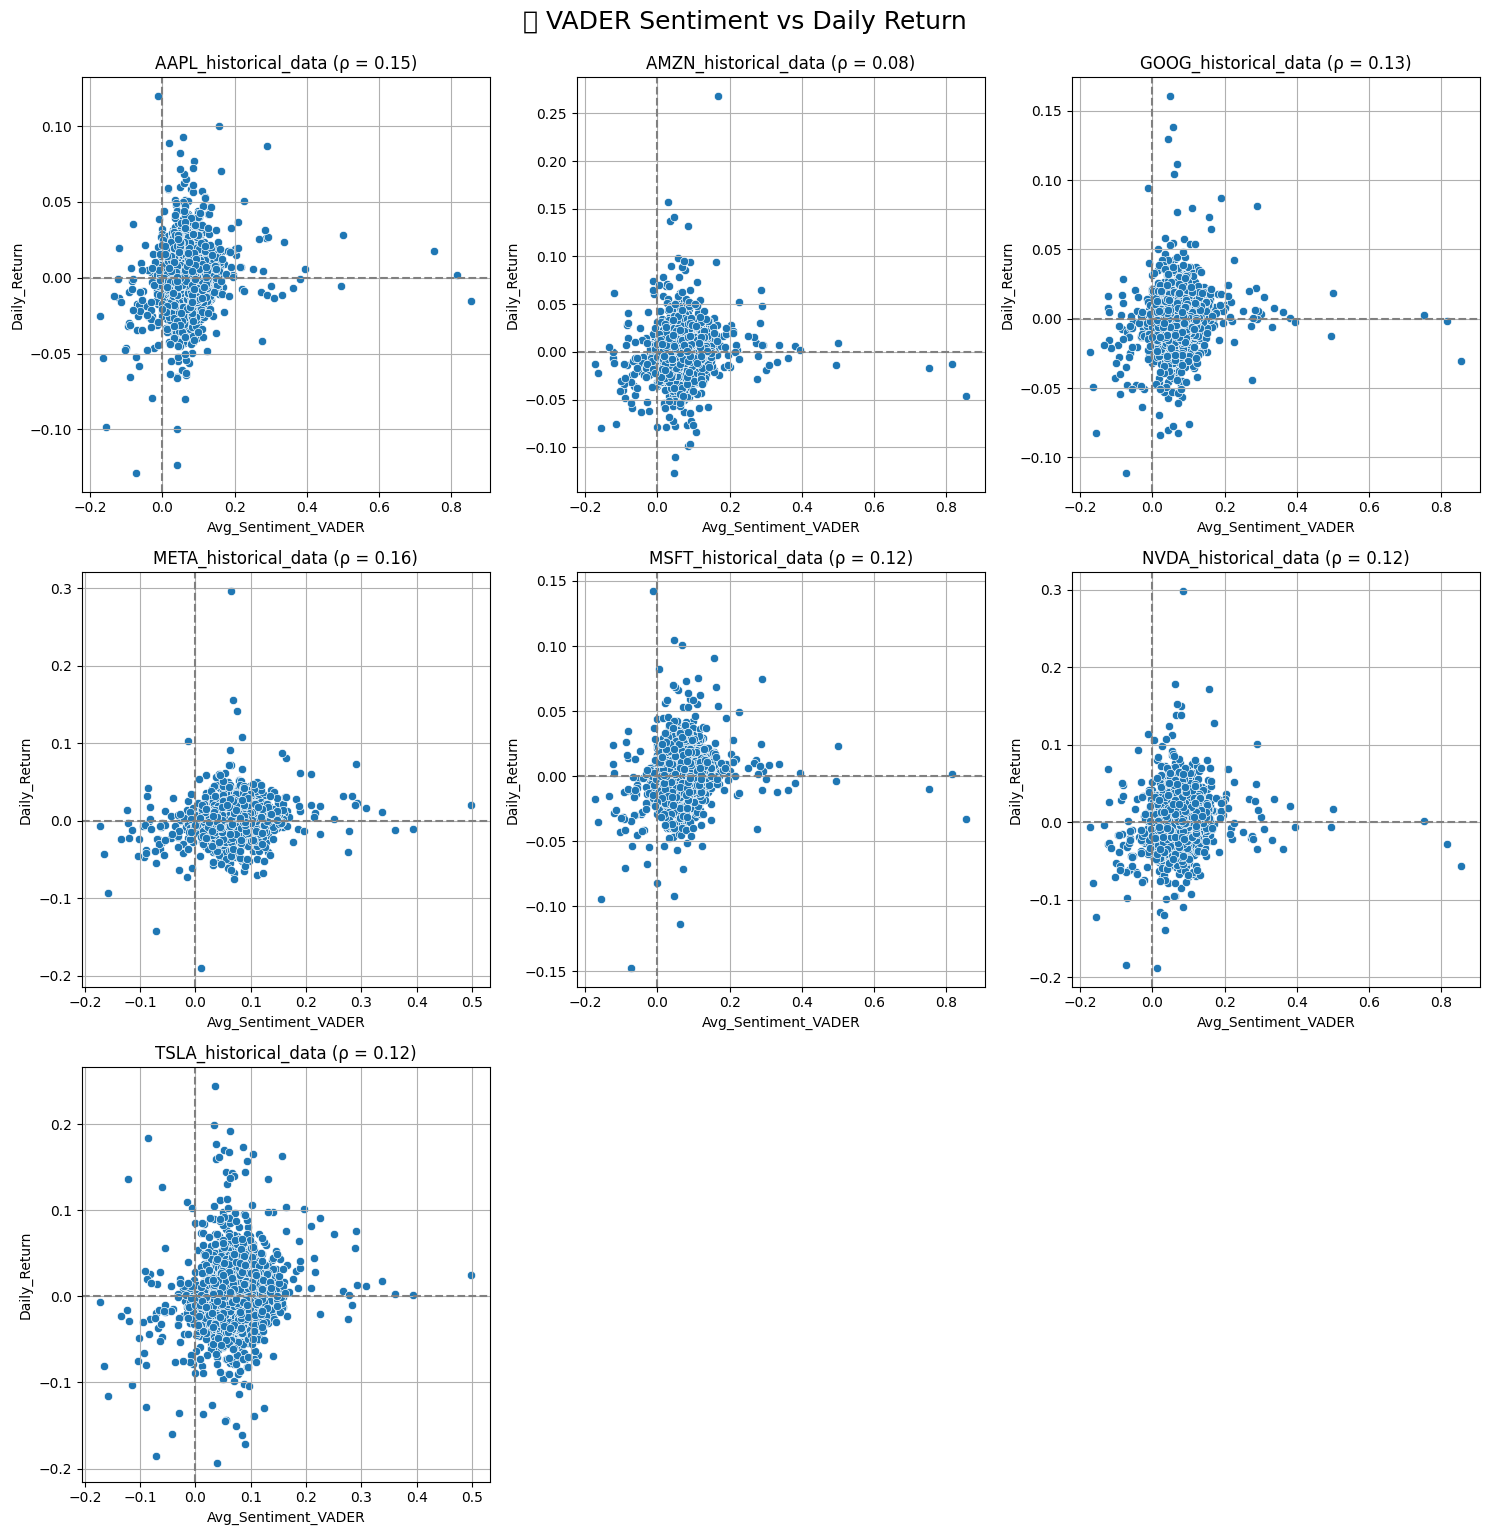

In [6]:
# Run for VADER
vader_results = process_stock_files(daily_sentiment_vader, 'Avg_Sentiment_VADER', 'VADER')
plot_correlation_grid(vader_results, 'Avg_Sentiment_VADER', 'VADER')
        

📊 TextBlob | AAPL_historical_data: Correlation = 0.0455
📊 TextBlob | AMZN_historical_data: Correlation = 0.0058
📊 TextBlob | GOOG_historical_data: Correlation = 0.0173
📊 TextBlob | META_historical_data: Correlation = 0.0877
📊 TextBlob | MSFT_historical_data: Correlation = 0.0328
📊 TextBlob | NVDA_historical_data: Correlation = -0.0264
📊 TextBlob | TSLA_historical_data: Correlation = 0.0498


C:\Users\user\AppData\Local\Temp\ipykernel_14144\1595436494.py:50: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(f"sentiment_vs_return_{label.lower()}.png", bbox_inches='tight')
c:\Users\user\Desktop\Predicting-Price-Moves-with-News-Sentiment\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


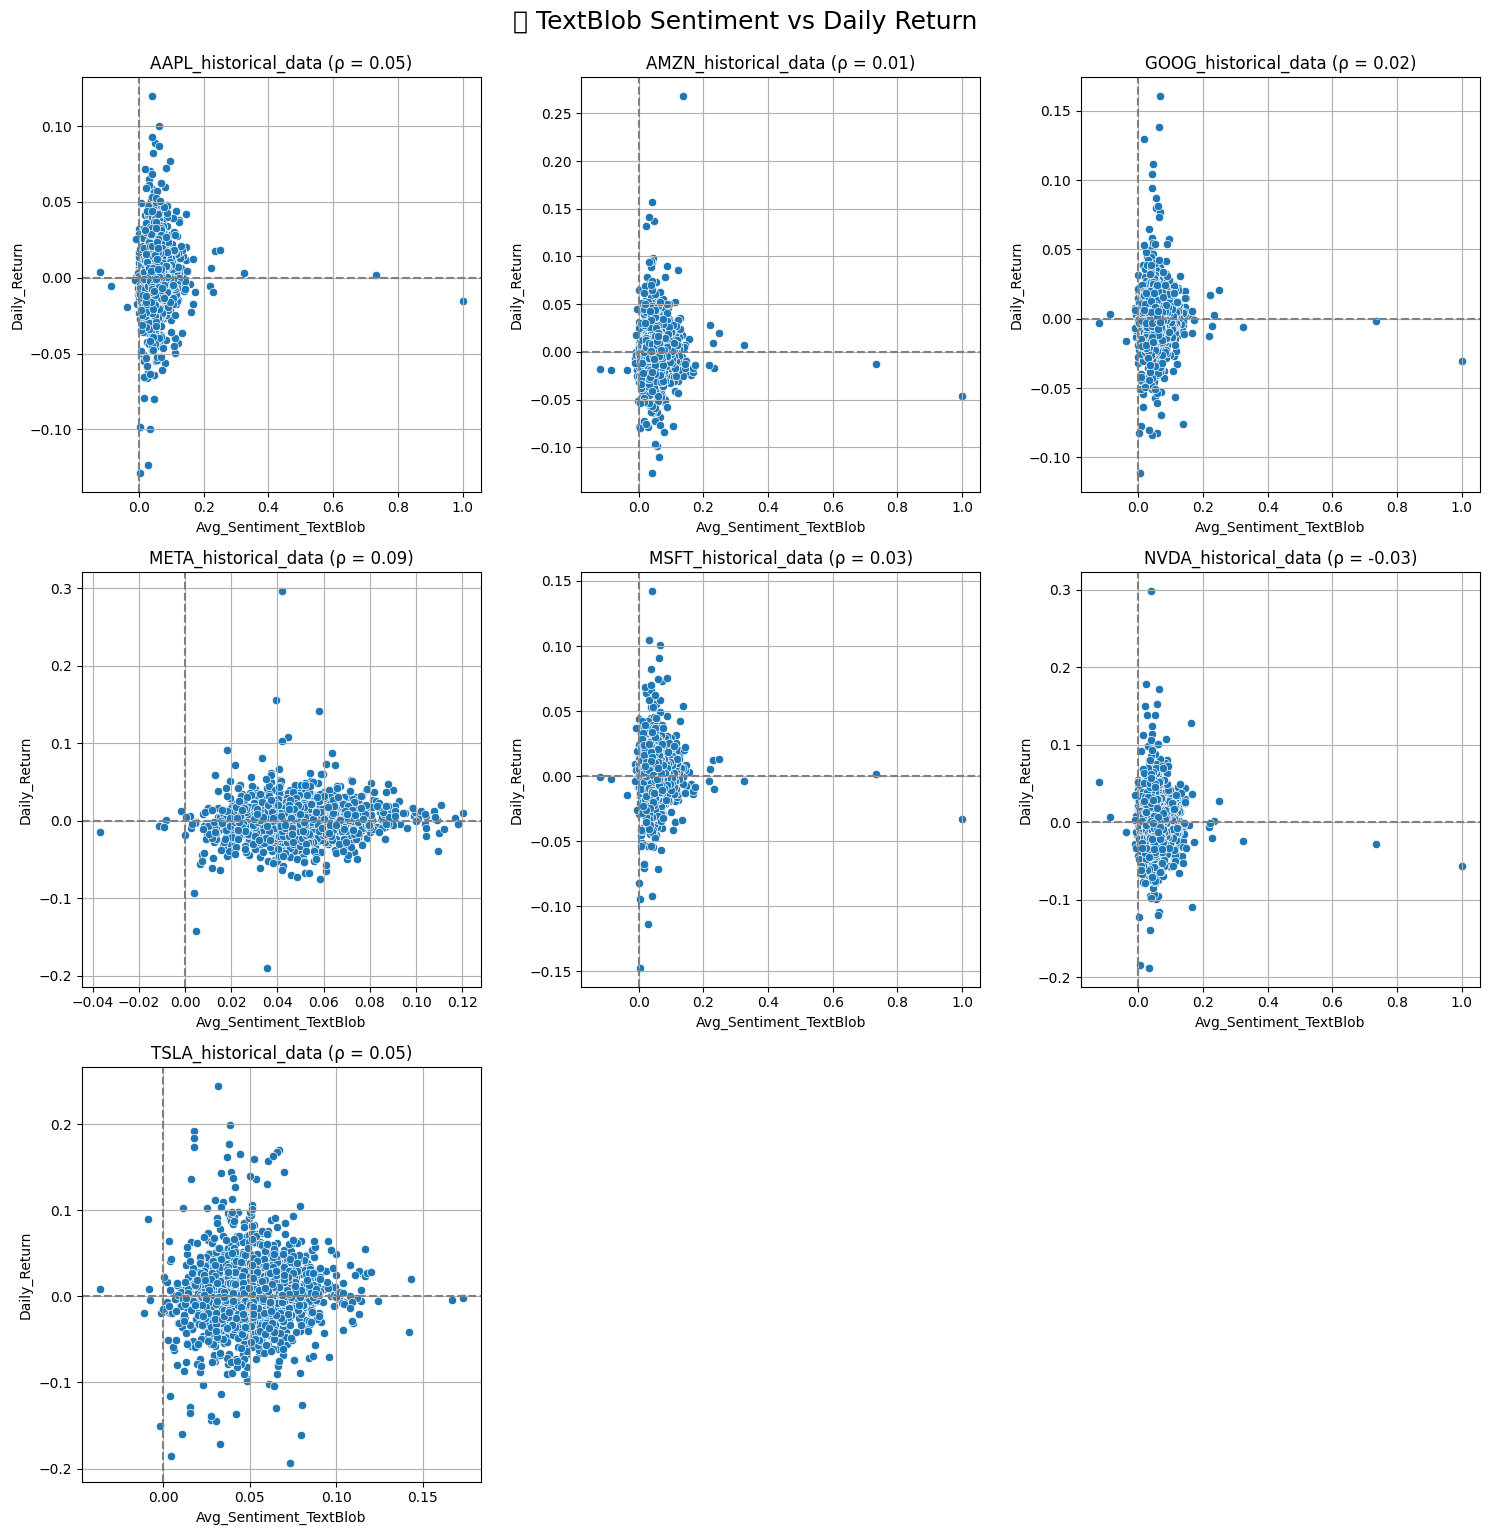

In [7]:
# Run for TextBlob
textblob_results = process_stock_files(daily_sentiment_textblob, 'Avg_Sentiment_TextBlob', 'TextBlob')
plot_correlation_grid(textblob_results, 'Avg_Sentiment_TextBlob', 'TextBlob')